## Assignment 1 - Classification


## Learning Outcomes


* Data exploration and pre-processing

* Develop a pipeline to carry out classification

* Compare different metrics and classifiers

The objective is to predict whether or not a credit card client will default for their payment in the next month. We will be using the better of 2 classifiers namely, Random Forest and KNN Classifier, and determine the best of a given set of hyperparameters by using grid search.


# Global Functions

**Questions (12 marks total)**

Q1.  Explore the credit card data set provided. You can also access it from the this link 

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
(https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

The data is open for public use and no authorizations are required.

You will build a classification model for this default of credit card clients dataset.  The objective is to predict whether or not a credit card client will default for their payment in the next month.

Make sure you perform your analyses and answer the questions in sections below:

1. Data exploration:  ( 3 marks) 

    - Explore the data ( for example look at the data, plot graphs ( histogram, pair plots)
    
2. Data Preprocessing: (4 marks)

    - Make sure you build a full data pipeline ( ie., use the pipeline to apply transformers and estimators- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html )
    - Do you require any data pre-processing? Are all the features useful? (Use only raw features from this dataset, in other words, no need to create feature crosses or new features)
    - Set the random seed to 123 (For splitting or any other random algorithm)
    - Split data into training (80%) and testing (20%)
    - Use Cross-validation with 5-folds
    - For other parameters, use default

3. Classification: (5 marks)

    - Study the ROC Curve, decide threshold
    - Use 2 classifiers.
    
         a. Random Forest
            - tune only: n_estimators: {4, 5, 10, 20, 50}.  We will be running random forest model using GridSearchCV, determine the best hyperparameter for the given list of n_estimators {4, 5, 10, 20, 50}. n_estimators refers to the number of trees in the forest. We will use CV = 5 and the scoring to be the roc_auc (area under the curve)
          
       b. KNN Classfier 
            - tune only: n_neighbors: {3, 5, 10, 20}. You may perform similar GridSearchCV as in the previous exercise with a given list of n_neightbors. 
        
    - Which one performs better in the cross validation? Note down your observations and give comments.
    
You may refer to the documentation for RandomForests and KNN Classifiers, for the different parameters and options available in the scikit-learn library.
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html



#### Conclusions 
(3 marks)

Explain your results and choices

In [652]:
## Use this for consistency in graphs through out the notebook
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline #each pipeline can have multiple steps
from sklearn.compose import ColumnTransformer #for selecting specific columns and transforming them with individual pipelines
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder #specific transformations we want to use in our pipelines
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

##plot a pie chart for the target to see if data are balanced
def check_data_balance(series, style="ggplot"):
    with plt.style.context(style):
        unique = series.value_counts()
        display(unique)  # shows unique value counts of the target
        plt.pie(unique, 
                explode=[0.05]*len(unique), 
                labels=unique.index, 
                autopct='%1.1f%%')
        plt.show() 

# Load Data

In [653]:
## Dataset
filepath = url = 'https://raw.githubusercontent.com/JordanVercillo/data_science/main/machine_learning/assignments/default%20of%20credit%20card%20clients.xls'

df = pd.read_excel(url, sheet_name=0, skiprows=1, header=0, engine='xlrd') 

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Data Exploration

In [654]:
#Clean Copy
df_discovery = df.copy()
df_discovery.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [655]:
print(df_discovery.isnull().sum().sum(), " missing values in the dataset.")

0  missing values in the dataset.


In [656]:
df_discovery.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


# Is it a balanced dataset?

default payment next month
0    23364
1     6636
Name: count, dtype: int64

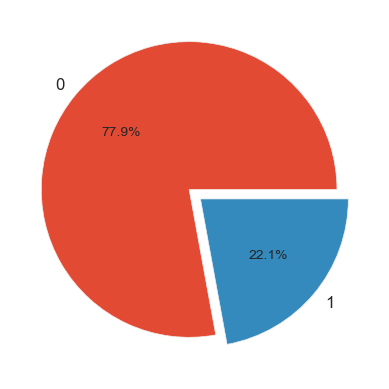

In [657]:
check_data_balance(df_discovery["default payment next month"])

# Histograms

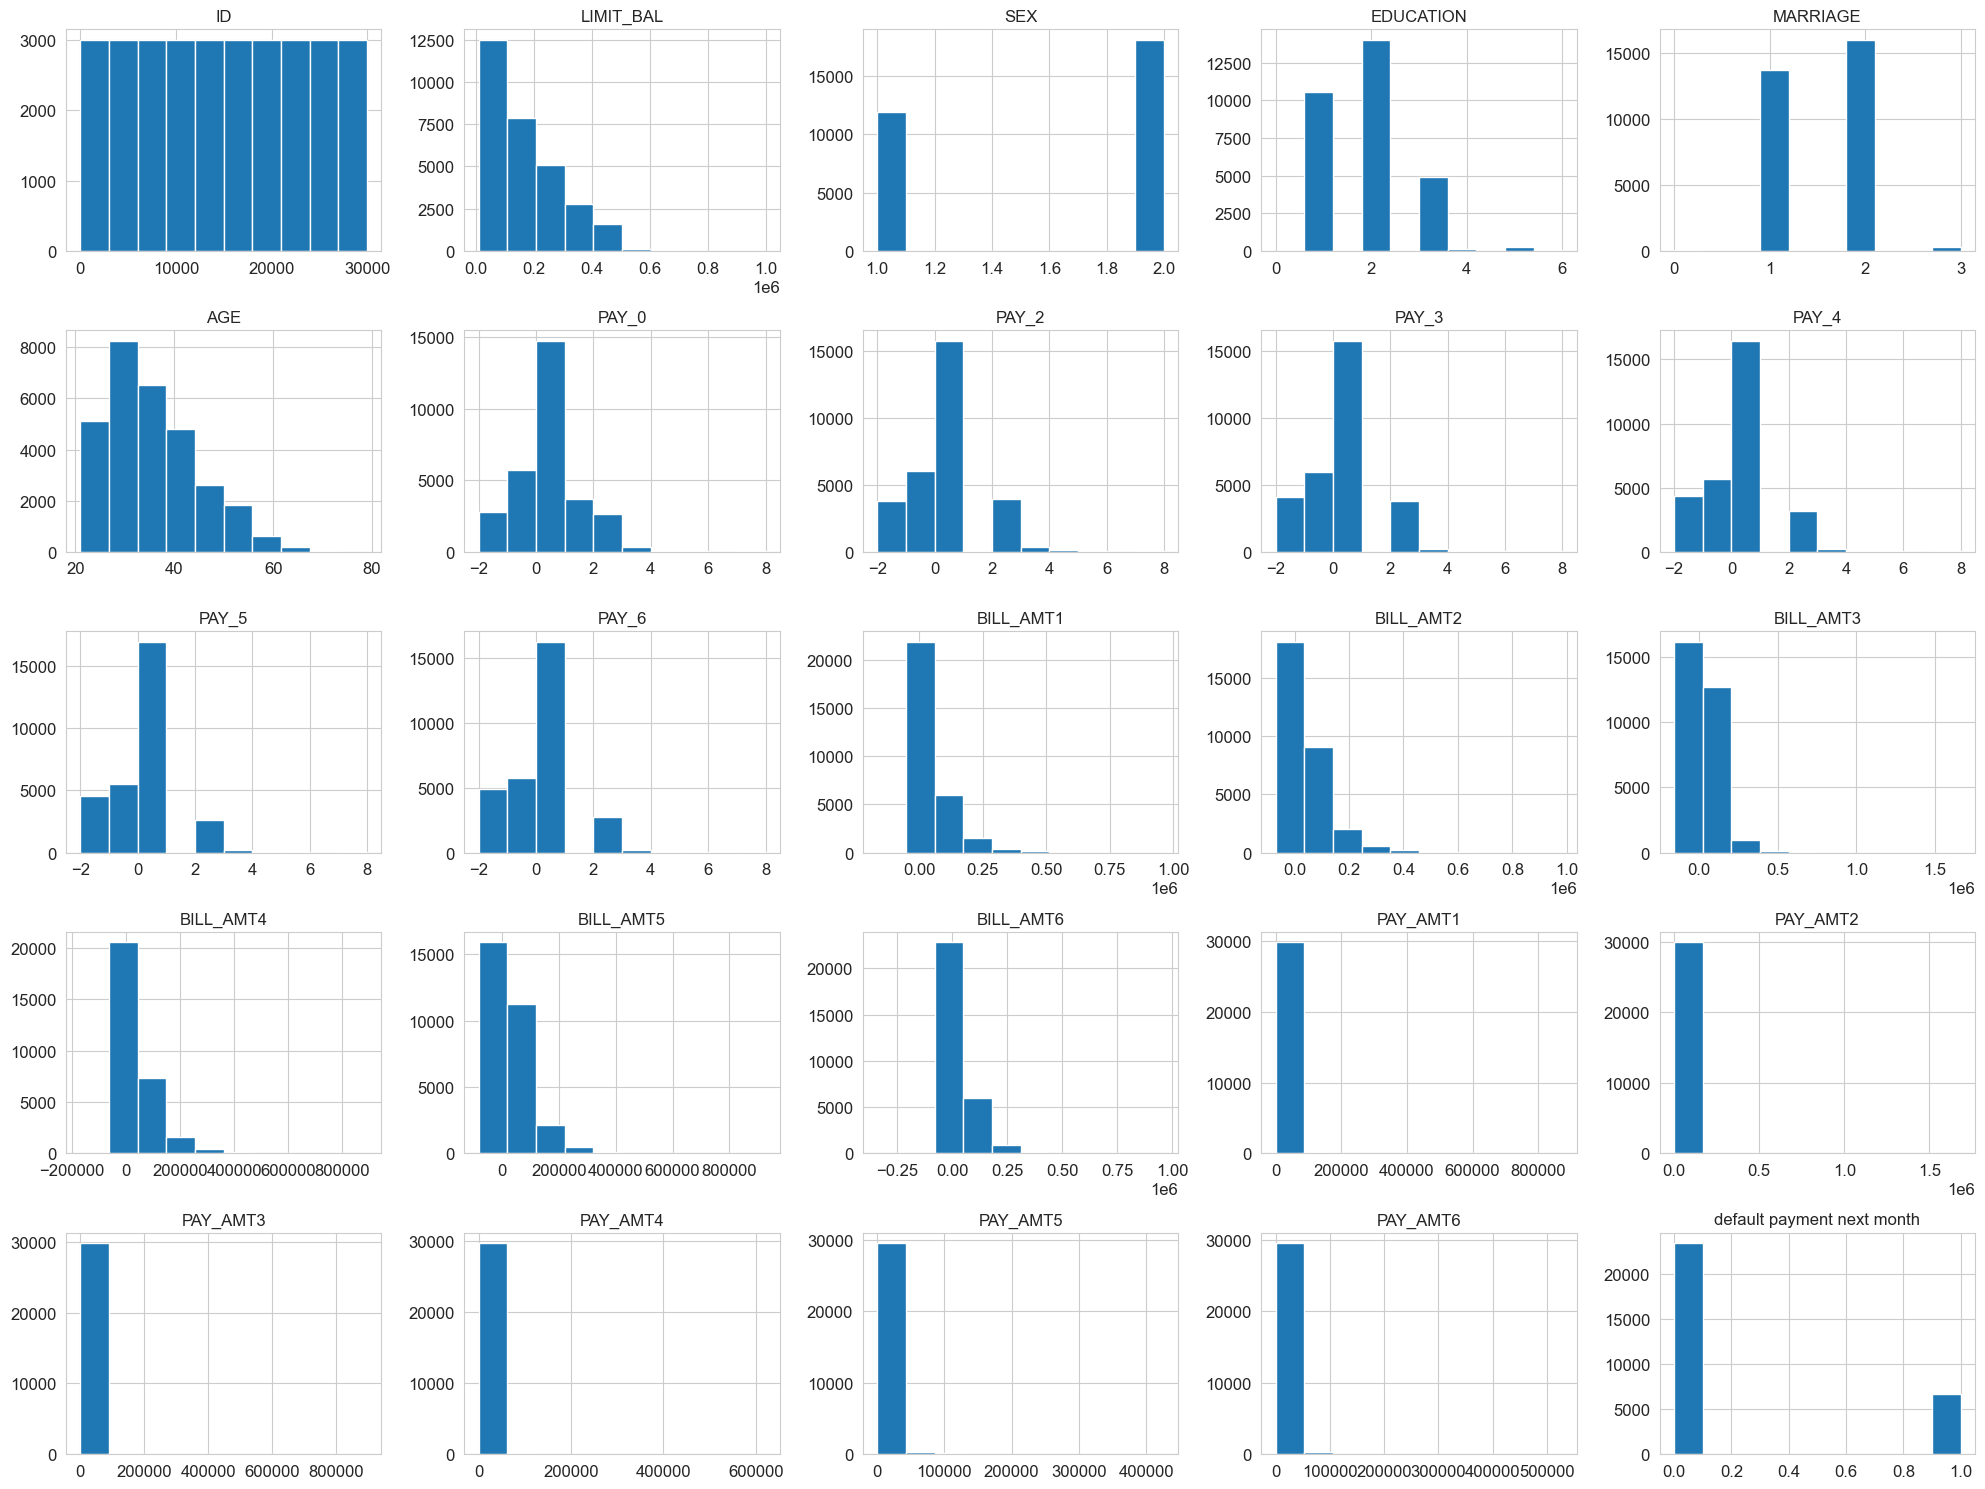

In [658]:
df_discovery.hist(figsize=(20,15))
plt.tight_layout()
plt.show()

In [659]:
TARGET = "default payment next month"
columns_predictors = [col for col in df.columns if col not in [TARGET]]
columns_categorical = ["SEX", "EDUCATION", "MARRIAGE", "PAY_0", "PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]
columns_numerical = [col for col in columns_predictors if col not in columns_categorical]
print(f"TARGET: {TARGET}")
print(f"columns_predictors: {columns_predictors}")
print(f"columns_categorical: {columns_categorical}")
print(f"columns_numerical: {columns_numerical}")

TARGET: default payment next month
columns_predictors: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
columns_categorical: ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
columns_numerical: ['ID', 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [660]:
for col in columns_categorical:
    print(f"\n{col} value counts:")
    display(df_discovery[col].value_counts(normalize=True))


SEX value counts:


SEX
2    0.603733
1    0.396267
Name: proportion, dtype: float64


EDUCATION value counts:


EDUCATION
2    0.467667
1    0.352833
3    0.163900
5    0.009333
4    0.004100
6    0.001700
0    0.000467
Name: proportion, dtype: float64


MARRIAGE value counts:


MARRIAGE
2    0.532133
1    0.455300
3    0.010767
0    0.001800
Name: proportion, dtype: float64


PAY_0 value counts:


PAY_0
 0    0.491233
-1    0.189533
 1    0.122933
-2    0.091967
 2    0.088900
 3    0.010733
 4    0.002533
 5    0.000867
 8    0.000633
 6    0.000367
 7    0.000300
Name: proportion, dtype: float64


PAY_2 value counts:


PAY_2
 0    0.524333
-1    0.201667
 2    0.130900
-2    0.126067
 3    0.010867
 4    0.003300
 1    0.000933
 5    0.000833
 7    0.000667
 6    0.000400
 8    0.000033
Name: proportion, dtype: float64


PAY_3 value counts:


PAY_3
 0    0.525467
-1    0.197933
-2    0.136167
 2    0.127300
 3    0.008000
 4    0.002533
 7    0.000900
 6    0.000767
 5    0.000700
 1    0.000133
 8    0.000100
Name: proportion, dtype: float64


PAY_4 value counts:


PAY_4
 0    0.548500
-1    0.189567
-2    0.144933
 2    0.105300
 3    0.006000
 4    0.002300
 7    0.001933
 5    0.001167
 6    0.000167
 1    0.000067
 8    0.000067
Name: proportion, dtype: float64


PAY_5 value counts:


PAY_5
 0    0.564900
-1    0.184633
-2    0.151533
 2    0.087533
 3    0.005933
 4    0.002800
 7    0.001933
 5    0.000567
 6    0.000133
 8    0.000033
Name: proportion, dtype: float64


PAY_6 value counts:


PAY_6
 0    0.542867
-1    0.191333
-2    0.163167
 2    0.092200
 3    0.006133
 4    0.001633
 7    0.001533
 6    0.000633
 5    0.000433
 8    0.000067
Name: proportion, dtype: float64

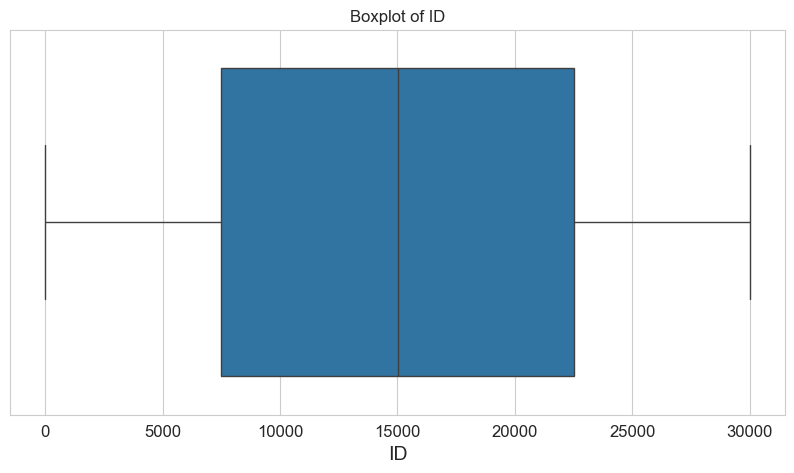

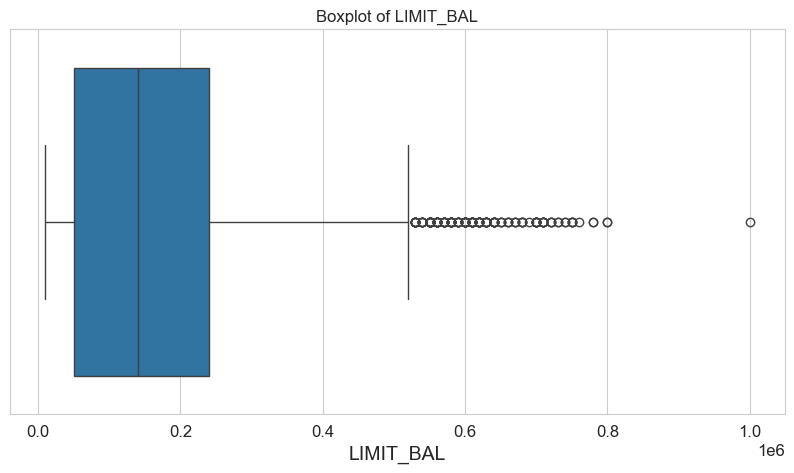

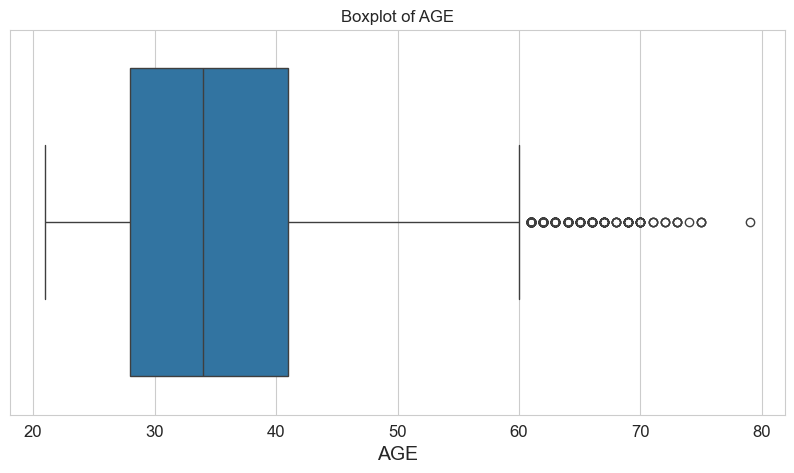

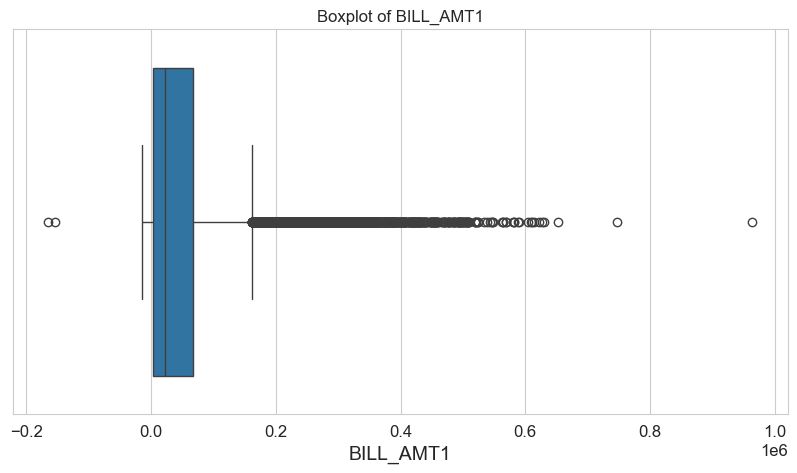

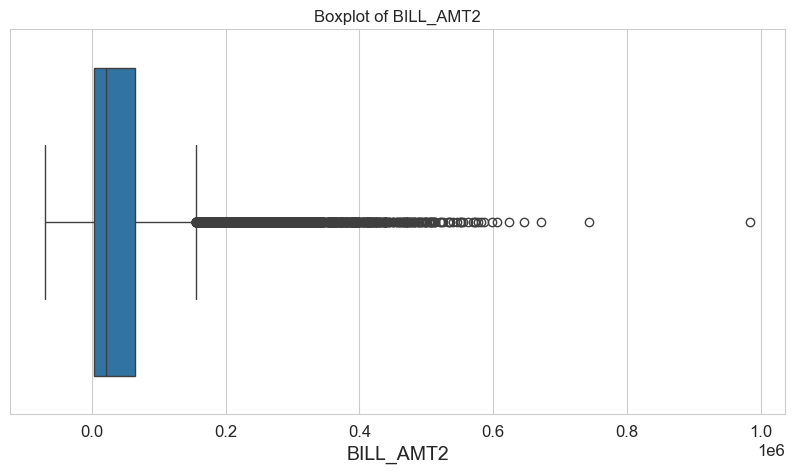

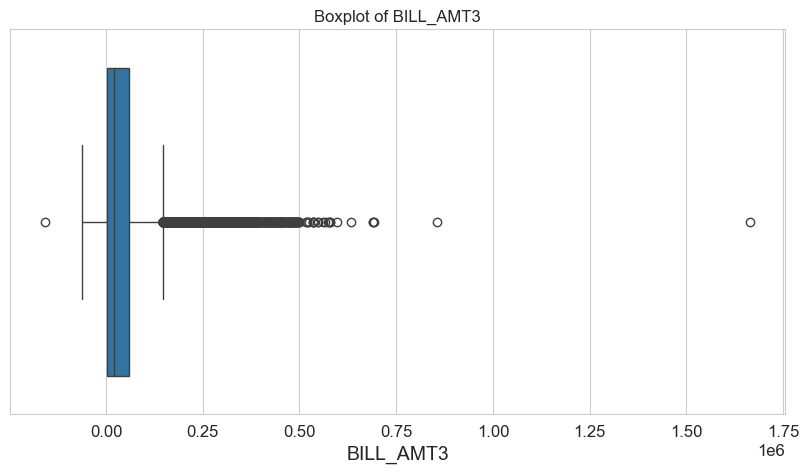

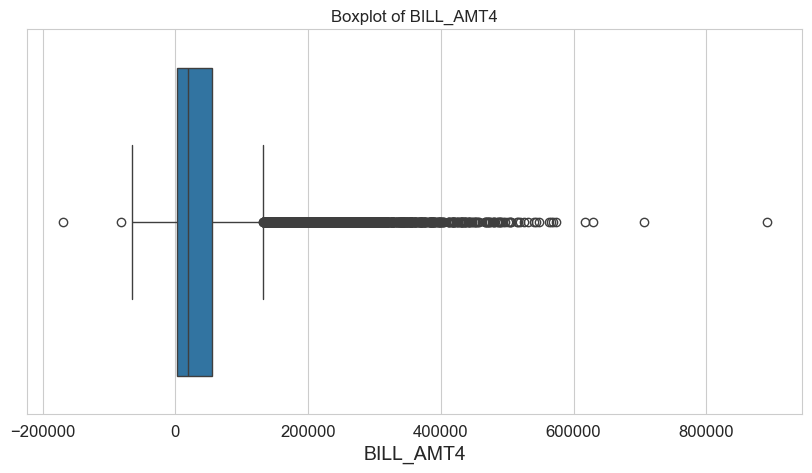

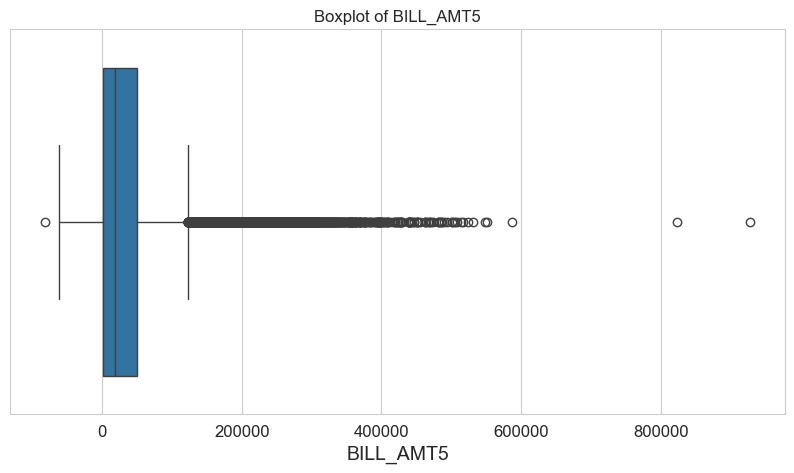

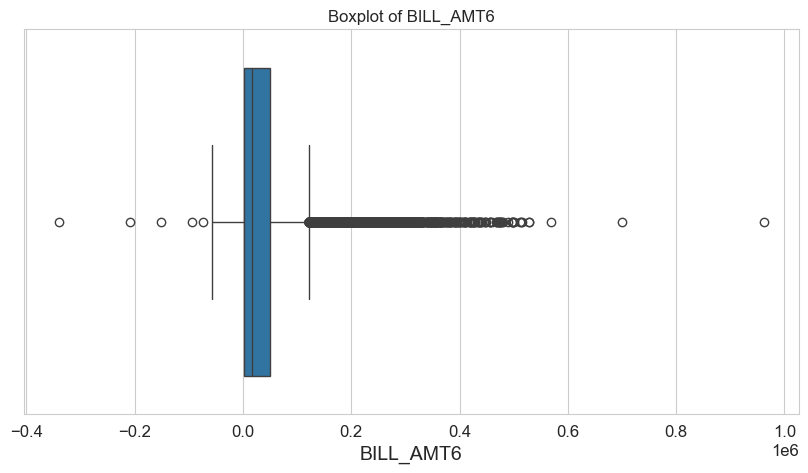

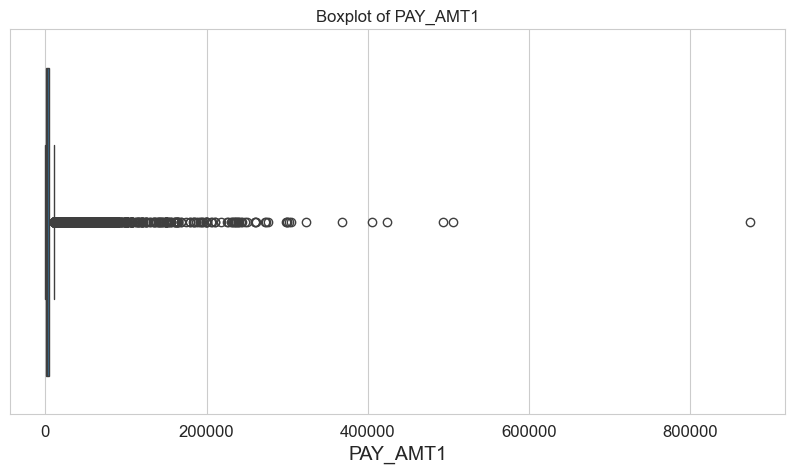

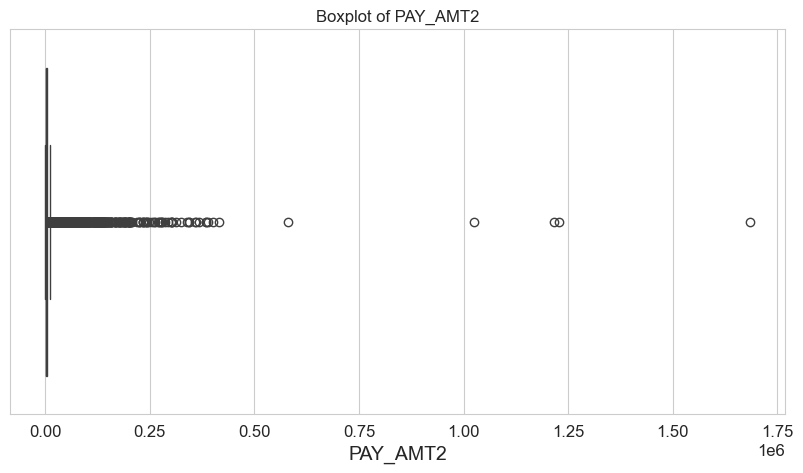

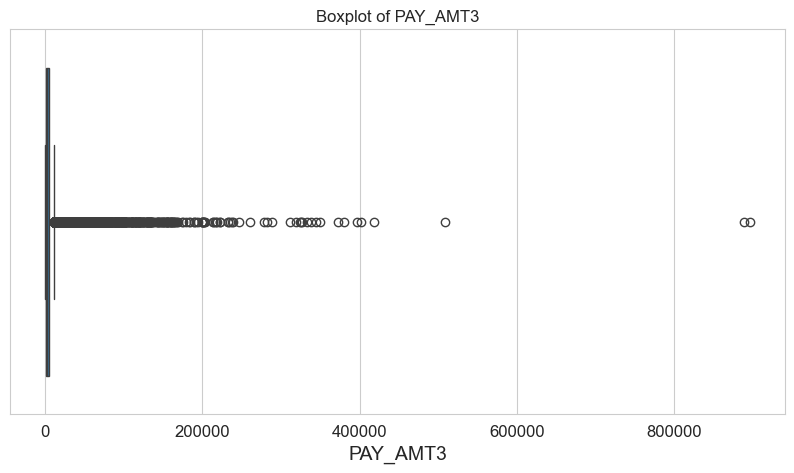

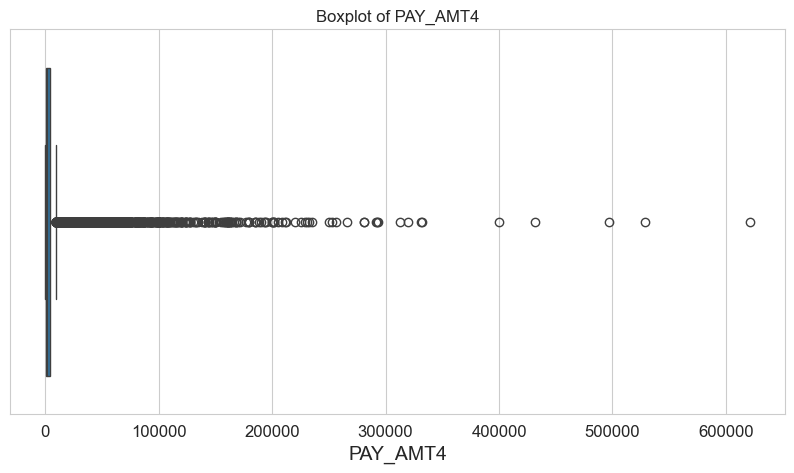

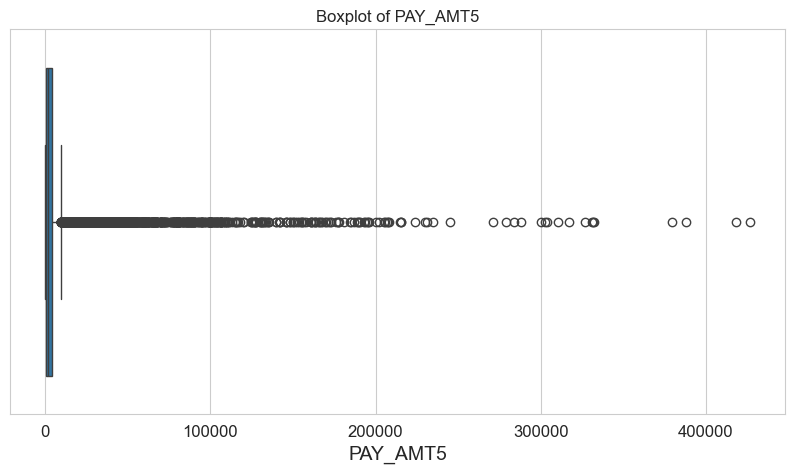

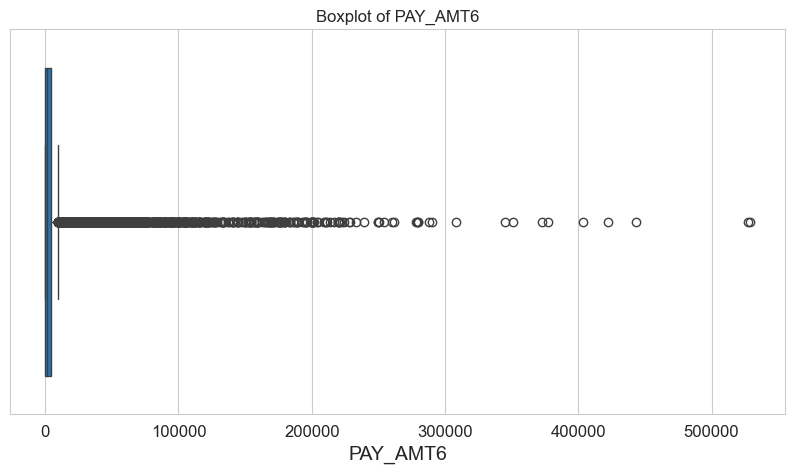

In [661]:
for col in columns_numerical:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df_discovery[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [662]:
df_discovery[columns_numerical].skew()

ID            0.000000
LIMIT_BAL     0.992867
AGE           0.732246
BILL_AMT1     2.663861
BILL_AMT2     2.705221
BILL_AMT3     3.087830
BILL_AMT4     2.821965
BILL_AMT5     2.876380
BILL_AMT6     2.846645
PAY_AMT1     14.668364
PAY_AMT2     30.453817
PAY_AMT3     17.216635
PAY_AMT4     12.904985
PAY_AMT5     11.127417
PAY_AMT6     10.640727
dtype: float64

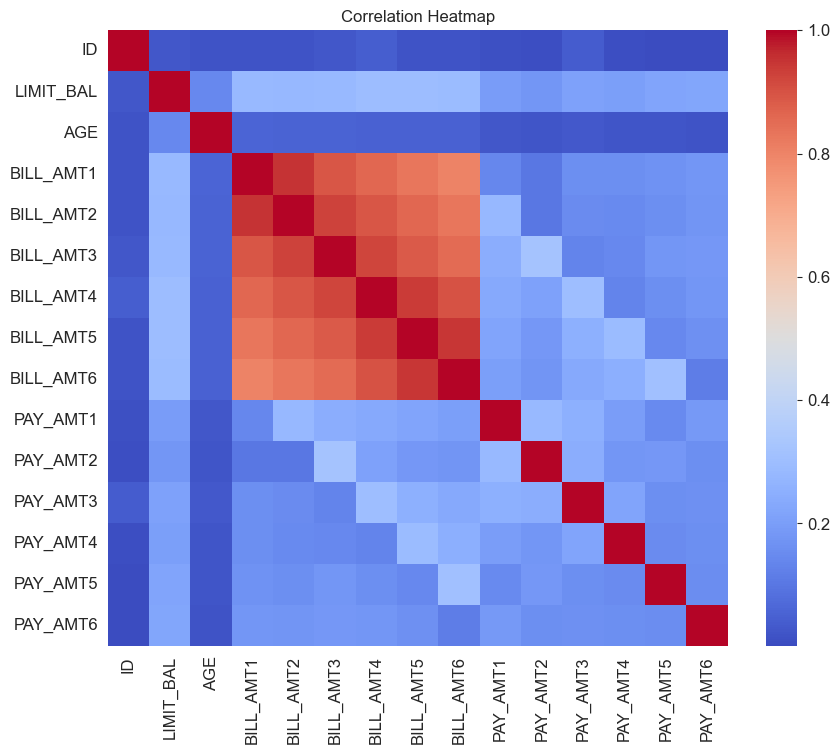

In [663]:
corr = df[columns_numerical].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Machine Learning

## Choose X and y

In [664]:
X = df[columns_predictors]
y = df[TARGET]
display(X)
display(y)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,20000,2,2,1,24,2,2,-1,-1,...,689,0,0,0,0,689,0,0,0,0
1,2,120000,2,2,2,26,-1,2,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,3,90000,2,2,2,34,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,4,50000,2,2,1,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,5,50000,1,2,1,57,-1,0,-1,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,3502,8979,5190,0,1837,3526,8998,129,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,2758,20878,20582,19357,0,0,22000,4200,2000,3100
29998,29999,80000,1,3,1,41,1,-1,0,0,...,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804


0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: default payment next month, Length: 30000, dtype: int64

## Train-test split

In [665]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10086, stratify=y) #stratified sampling based on the target
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (24000, 24)
X_test.shape: (6000, 24)
y_train.shape: (24000,)
y_test.shape: (6000,)


In [666]:
display(X_train)
display(y_train)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
324,325,360000,2,2,2,32,0,0,0,0,...,91834,95631,100123,100738,10000,7000,10000,10000,10000,10000
26345,26346,200000,2,1,2,29,-1,-1,-1,0,...,9781,29313,49113,732,0,9781,20000,20000,732,1005
17150,17151,140000,2,1,2,28,0,0,0,0,...,11349,12661,12606,12869,1500,1195,1507,452,467,470
27838,27839,80000,2,1,2,26,0,-1,-1,2,...,2281,1356,355,-520,376,2281,0,0,0,35893
9945,9946,250000,2,1,2,35,-2,-2,-2,-2,...,26267,26599,2948,2065,0,26267,532,2948,2065,13780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14525,14526,180000,1,2,2,43,0,0,0,0,...,171820,160018,164717,151235,7500,5900,6000,7000,7000,5000
21158,21159,180000,1,2,2,39,0,0,0,0,...,124553,127096,128992,131660,4500,6000,6100,5500,4900,5500
21217,21218,50000,1,2,2,37,2,2,2,2,...,75322,71640,71114,67519,7300,3200,0,3000,5400,5000
26563,26564,50000,2,3,2,56,0,0,0,0,...,50417,48371,15417,16194,1798,2058,1683,600,1017,20698


324      0
26345    0
17150    0
27838    0
9945     0
        ..
14525    0
21158    0
21217    1
26563    0
21190    0
Name: default payment next month, Length: 24000, dtype: int64

default payment next month
0    18691
1     5309
Name: count, dtype: int64

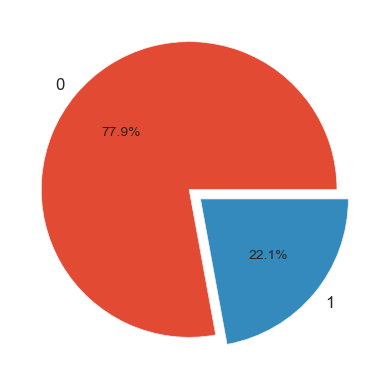

In [667]:
check_data_balance(y_train)

default payment next month
0    4673
1    1327
Name: count, dtype: int64

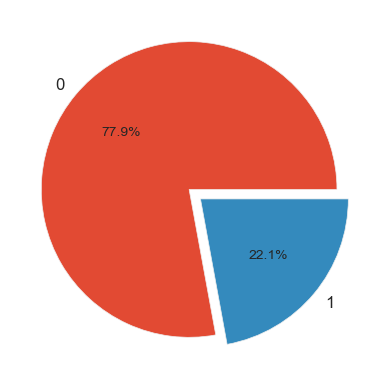

In [668]:
check_data_balance(y_test)

## Preprocessing with pipelines 🚀

### Define the pipeline(s)

In [669]:
pipeline_categorical = Pipeline([
  ('onehot', OneHotEncoder(handle_unknown="ignore")),
])

pipeline_numerical = Pipeline([
  ('scaler', MinMaxScaler(feature_range=(0,1))),
])

pipeline_full = ColumnTransformer([
  ("categorical", pipeline_categorical, columns_categorical),
  ("numerical", pipeline_numerical, columns_numerical),
])

In [670]:
pipeline_full

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
                                  'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                                  'PAY_6']),
                                ('numerical',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['ID', 'LIMIT_BAL', 'AGE', 'BILL_AMT1',
                                  'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
                                  'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                                  'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
                                  'PAY_AMT5', 'PAY_AMT6'])])

In [671]:
X_train[columns_categorical]

,SEX,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
324,2,2,2,0,0,0,0,0,0
26345,2,1,2,-1,-1,-1,0,0,-1
17150,2,1,2,0,0,0,0,0,0
27838,2,1,2,0,-1,-1,2,2,2
9945,2,1,2,-2,-2,-2,-2,-2,-2
...,...,...,...,...,...,...,...,...,...
14525,1,2,2,0,0,0,0,0,0
21158,1,2,2,0,0,0,0,0,0
21217,1,2,2,2,2,2,2,0,0
26563,2,3,2,0,0,0,0,0,0


## Testing

In [672]:
# testing
# pipeline_numerical.fit_transform(X_train[columns_numerical]).shape
# pipeline_categorical.fit_transform(X_train[columns_categorical]).toarray().shape
# pipeline_full.fit_transform(X_train).toarray().shape

## Apply the pipeline

In [673]:
pipeline_full.fit(X_train)
X_train_transformed = pipeline_full.transform(X_train)
X_test_transformed = pipeline_full.transform(X_test)
print(f"X_train_transformed.shape: {X_train_transformed.shape}")
print(f"X_test_transformed.shape: {X_test_transformed.shape}")

X_train_transformed.shape: (24000, 92)
X_test_transformed.shape: (6000, 92)


# Hyperparameter Tuning

In [674]:
# Random Forest Grid Search
rf_param_grid = {
    "n_estimators": [4, 5, 10, 20, 50]
}

rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=123),
    rf_param_grid,
    scoring="roc_auc",
    cv=5,  # 5-fold Cross Validation
    n_jobs=-1,
    verbose=2
)
rf_grid_search.fit(X_train_transformed, y_train)

# Extracting the best model and hyperparameters
best_rf = rf_grid_search.best_estimator_
print("Random Forest best params:", rf_grid_search.best_params_)
print("Random Forest best score (CV AUC):", rf_grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Random Forest best params: {'n_estimators': 50}
Random Forest best score (CV AUC): 0.7631664737594648


In [675]:
# KNN Grid Search
knn_param_grid = {
    "n_neighbors": [3, 5, 10, 20]
}

knn_grid_search = GridSearchCV(
    KNeighborsClassifier(),
    knn_param_grid,
    scoring="roc_auc",
    cv=5,  # 5-fold Cross Validation
    n_jobs=-1,
    verbose=2
)
knn_grid_search.fit(X_train_transformed, y_train)

# Extracting the best model and hyperparameters
best_knn = knn_grid_search.best_estimator_
print("KNN best params:", knn_grid_search.best_params_)
print("KNN best score (CV AUC):", knn_grid_search.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
KNN best params: {'n_neighbors': 20}
KNN best score (CV AUC): 0.7373200110293013


# Train random_forest_model on the transformed training set

In [676]:
%%time

random_forest_model = RandomForestClassifier(n_estimators=50, random_state=123)
random_forest_model.fit(X_train_transformed, y_train)
y_pred_rf= random_forest_model.predict(X_test_transformed)
print(f"accuracy_score: {accuracy_score(y_test, y_pred_rf)}")

accuracy_score: 0.8143333333333334
CPU times: total: 7.56 s
Wall time: 7.57 s


In [677]:
y_pred_rf = random_forest_model.predict(X_test_transformed)
y_pred_proba_rf = random_forest_model.predict_proba(X_test_transformed)[:, 1] #to calculate ROC_AUC, we need model.predict_proba() instead of model.pred()

# Define custom thresholds
threshold_rf = 0.3  # For Random Forest

# Convert Probabilities to Class Predictions Using Custom Threshold
y_pred_rf_custom = (y_pred_proba_rf >= threshold_rf).astype(int)


# Precision-Recall for Random Forest
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_pred_proba_rf)


print("\nRandom Forest Metrics with Custom Threshold:")
print(f"accuracy_score: {accuracy_score(y_test, y_pred_rf_custom)}")
print(f"precision_score: {precision_score(y_test, y_pred_rf_custom)}")
print(f"recall_score: {recall_score(y_test, y_pred_rf_custom)}")
print(f"f1_score: {f1_score(y_test, y_pred_rf_custom)}")
print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_proba_rf)}")

df_pr_rf = pd.DataFrame({
    'precision': precision_rf[:-1],
    'recall': recall_rf[:-1],
    'threshold': thresholds_rf
})
display(df_pr_rf.head())



Random Forest Metrics with Custom Threshold:
accuracy_score: 0.7726666666666666
precision_score: 0.4879163945133899
recall_score: 0.5629238884702336
f1_score: 0.5227431770468859
roc_auc_score: 0.7558417731388657


,precision,recall,threshold
0,0.221167,1.000000,0.00
1,0.225520,0.996232,0.02
2,0.231633,0.978900,0.04
3,0.242476,0.959307,0.06
4,0.253952,0.932178,0.08


# Train knn_classfier_model on the transformed training set

In [678]:
%%time

knn_classfier_model =  KNeighborsClassifier(n_neighbors=20)
knn_classfier_model.fit(X_train_transformed, y_train)
y_pred_knn = knn_classfier_model.predict(X_test_transformed)
print(f"accuracy_score: {accuracy_score(y_test, y_pred_knn)}")

accuracy_score: 0.8148333333333333
CPU times: total: 4.83 s
Wall time: 4.84 s


In [679]:
y_pred_knn = knn_classfier_model.predict(X_test_transformed)
y_pred_proba_knn = knn_classfier_model.predict_proba(X_test_transformed)[:, 1] #to calculate ROC_AUC, we need model.predict_proba() instead of model.pred()

# Define custom thresholds
threshold_knn = 0.3  # For KNN

# Convert Probabilities to Class Predictions Using Custom Threshold
y_pred_knn_custom = (y_pred_proba_knn >= threshold_knn).astype(int)

# Precision-Recall for KNN
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_test, y_pred_proba_knn)

print("\nKNN Metrics with Custom Threshold:")
print(f"accuracy_score: {accuracy_score(y_test, y_pred_knn_custom)}")
print(f"precision_score: {precision_score(y_test, y_pred_knn_custom)}")
print(f"recall_score: {recall_score(y_test, y_pred_knn_custom)}")
print(f"f1_score: {f1_score(y_test, y_pred_knn_custom)}")
print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_proba_knn)}")

df_pr_knn = pd.DataFrame({
    'precision': precision_knn[:-1],
    'recall': recall_knn[:-1],
    'threshold': thresholds_knn
})
display(df_pr_knn.head())


KNN Metrics with Custom Threshold:
accuracy_score: 0.7783333333333333
precision_score: 0.4989106753812636
recall_score: 0.517709118311982
f1_score: 0.5081360946745562
roc_auc_score: 0.7307460275813645


,precision,recall,threshold
0,0.221167,1.000000,0.00
1,0.234545,0.972118,0.05
2,0.260380,0.888470,0.10
3,0.297643,0.770912,0.15
4,0.354618,0.665411,0.20


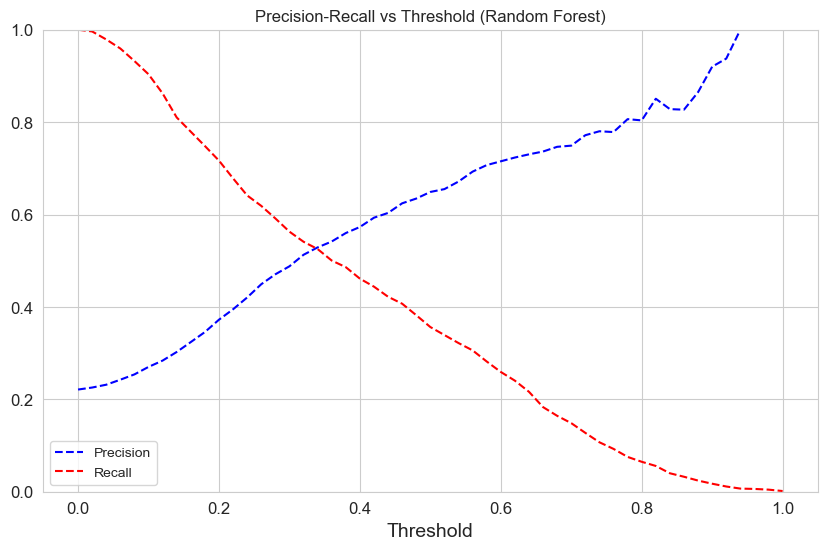

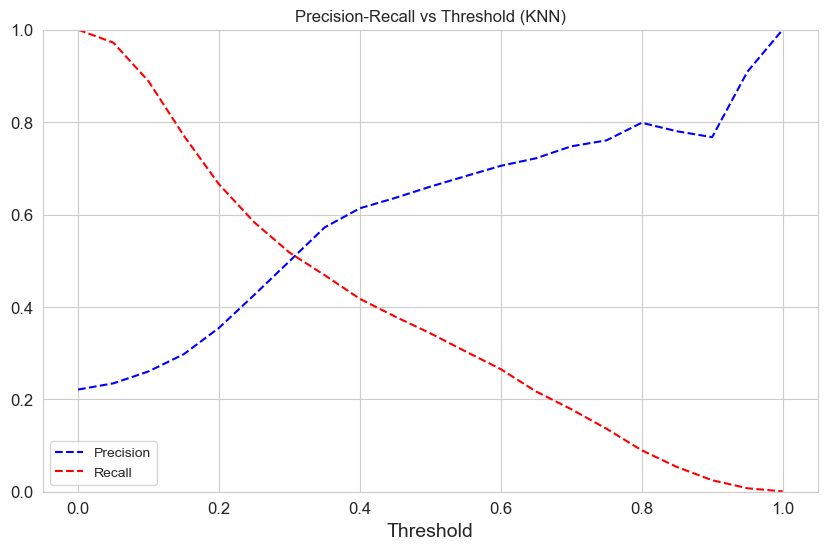

In [680]:
# Plot for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(thresholds_rf, precision_rf[:-1], 'b--', label='Precision')
plt.plot(thresholds_rf, recall_rf[:-1], 'r--', label='Recall')
plt.xlabel('Threshold')
plt.title('Precision-Recall vs Threshold (Random Forest)')
plt.legend(loc='lower left')
plt.ylim([0, 1])
plt.grid(True)
plt.show()

# Plot for KNN
plt.figure(figsize=(10, 6))
plt.plot(thresholds_knn, precision_knn[:-1], 'b--', label='Precision')
plt.plot(thresholds_knn, recall_knn[:-1], 'r--', label='Recall')
plt.xlabel('Threshold')
plt.title('Precision-Recall vs Threshold (KNN)')
plt.legend(loc='lower left')
plt.ylim([0, 1])
plt.grid(True)
plt.show()

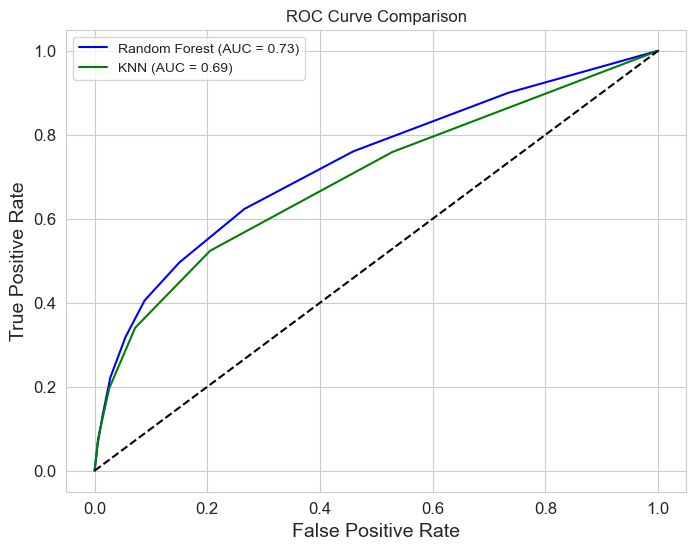

In [681]:

# Compute ROC curve and AUC for both models
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_pred_proba)

auc_rf = roc_auc_score(y_test, rf_pred_proba)
auc_knn = roc_auc_score(y_test, knn_pred_proba)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='blue')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

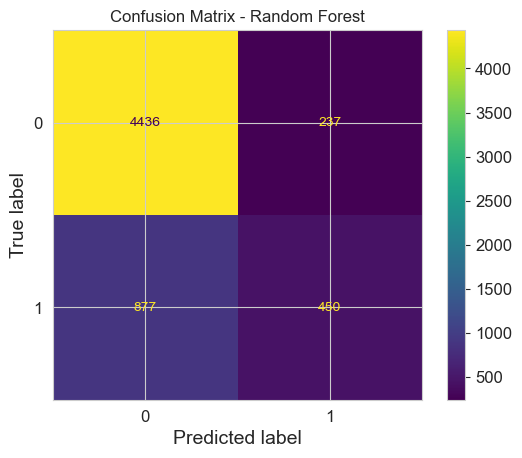

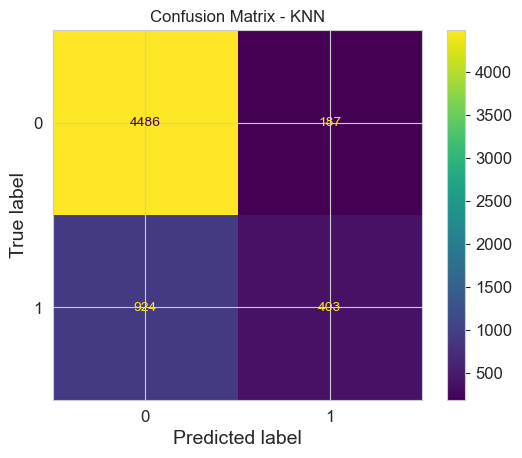

In [682]:
ConfusionMatrixDisplay.from_estimator(random_forest_model, X_test_transformed, y_test)
plt.title('Confusion Matrix - Random Forest')
plt.show()

ConfusionMatrixDisplay.from_estimator(knn_classfier_model, X_test_transformed, y_test)
plt.title('Confusion Matrix - KNN')
plt.show()